# Polarization Detection using DeBERTa with Class-Weighted Fine-tuning

**SemEval 2026 Task 9 - Subtask 1: Polarization Detection**

Approach: Fine-tuning DeBERTa-v3-base class weight buat atasi data imbalanced (semoga)

In [1]:
# Verify GPU
!nvidia-smi

Tue Dec  2 05:27:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies
!pip install -q transformers==4.44.0 accelerate scikit-learn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 74.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

2025-12-02 05:29:17.911075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764653358.083770      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764653358.132706      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch version: 2.6.0+cu124
CUDA available: True
Device: Tesla T4


In [4]:
# Load data
train_df = pd.read_csv('/kaggle/input/sharedtask-polar/subtask1/train/eng.csv')
dev_df = pd.read_csv('/kaggle/input/sharedtask-polar/subtask1/dev/eng.csv')

print(f"Training samples: {len(train_df)}")
print(f"Dev samples: {len(dev_df)}")
print(f"\nLabel distribution in training set:")
print(train_df['polarization'].value_counts())
print(f"\nClass ratio: {train_df['polarization'].value_counts(normalize=True).round(3).to_dict()}")

Training samples: 3222
Dev samples: 160

Label distribution in training set:
polarization
0    2047
1    1175
Name: count, dtype: int64

Class ratio: {0: 0.635, 1: 0.365}


In [5]:
#preprocessing
import re

def preprocess_text(text):
    """
    Preprocessing pipeline:
    1. remove URLs
    2. normalize whitespace
    3. handle special characters
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove @mentions tapi pertahanin konteks
    text = re.sub(r'@\w+', '', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#apply preprocessing
train_df['text_clean'] = train_df['text'].apply(preprocess_text)
dev_df['text_clean'] = dev_df['text'].apply(preprocess_text)

#contoh
print("Original:", train_df['text'].iloc[0])
print("Cleaned:", train_df['text_clean'].iloc[0])

Original:  is defending imperialism in the dnd chat
Cleaned: is defending imperialism in the dnd chat


In [7]:
#split buat val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text_clean'].tolist(),
    train_df['polarization'].tolist(),
    test_size=0.15,
    random_state=42,
    stratify=train_df['polarization']
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Training samples: 2738
Validation samples: 484


In [8]:
#calculate class weights, imbalanced data
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print(f"Class weights: {class_weights}")
print(f"  - Non-polarized (0): {class_weights[0]:.4f}")
print(f"  - Polarized (1): {class_weights[1]:.4f}")

Class weights: tensor([0.7868, 1.3717])
  - Non-polarized (0): 0.7868
  - Polarized (1): 1.3717


In [9]:
#model configuration
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

print(f"Model: {MODEL_NAME}")
print(f"Max Length: {MAX_LENGTH}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")

Model: microsoft/deberta-v3-base
Max Length: 256
Batch Size: 16
Epochs: 5
Learning Rate: 2e-05


In [10]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Tokenizer loaded: microsoft/deberta-v3-base


In [11]:
#dataset class
class PolarizationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

#create datasets
train_dataset = PolarizationDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = PolarizationDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 2738
Val dataset size: 484


In [12]:
#custom trainer with class weights
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

In [13]:
#load model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
print(f"Model loaded: {MODEL_NAME}")
print(f"Parameters: {model.num_parameters():,}")

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: microsoft/deberta-v3-base
Parameters: 184,423,682


In [14]:
# Metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    f1_macro = f1_score(labels, preds, average='macro')
    f1_binary = f1_score(labels, preds, average='binary')
    
    return {
        'f1_macro': f1_macro,
        'f1_polarized': f1_binary
    }

In [15]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    fp16=True,
    report_to="none",
    disable_tqdm=False
)

In [16]:
# inisialisasi trainer
trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Starting training...")
train_result = trainer.train()

Starting training...


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Polarized
1,0.661900,0.469621,0.786231,0.728814
2,0.407800,0.532701,0.800865,0.738739
3,0.294900,0.482805,0.779073,0.749403
4,0.210000,0.596824,0.803857,0.754821
5,0.140400,0.644969,0.815832,0.767507


In [17]:
# Evaluation on validation set
eval_results = trainer.evaluate()
print("\n" + "="*50)
print("VALIDATION RESULTS")
print("="*50)
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


VALIDATION RESULTS
eval_loss: 0.6450
eval_f1_macro: 0.8158
eval_f1_polarized: 0.7675
eval_runtime: 2.1198
eval_samples_per_second: 228.3230
eval_steps_per_second: 7.5480
epoch: 5.0000



Classification Report:
               precision    recall  f1-score   support

Non-Polarized       0.87      0.86      0.86       307
    Polarized       0.76      0.77      0.77       177

     accuracy                           0.83       484
    macro avg       0.81      0.82      0.82       484
 weighted avg       0.83      0.83      0.83       484



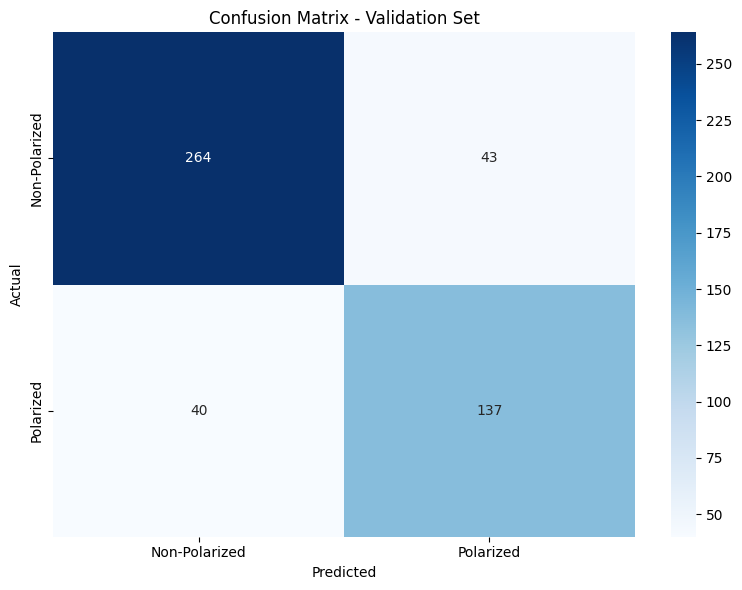

In [18]:
#classification report
val_predictions = trainer.predict(val_dataset)
val_preds = np.argmax(val_predictions.predictions, axis=1)

print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['Non-Polarized', 'Polarized']))

#conf matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Polarized', 'Polarized'],
            yticklabels=['Non-Polarized', 'Polarized'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

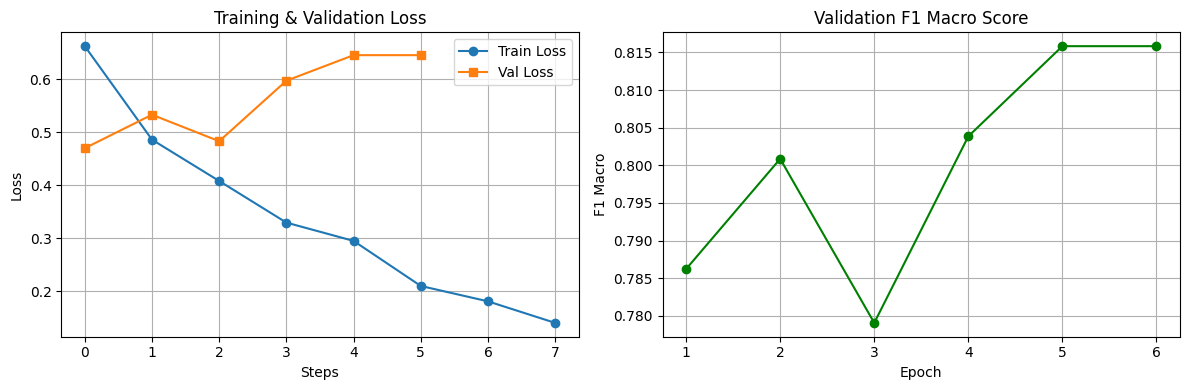

In [19]:
#training history visualisasi
history = trainer.state.log_history

train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_f1 = [x['eval_f1_macro'] for x in history if 'eval_f1_macro' in x]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#loss plot
axes[0].plot(train_loss, label='Train Loss', marker='o')
axes[0].plot(range(0, len(train_loss), len(train_loss)//len(eval_loss) if eval_loss else 1)[:len(eval_loss)], 
             eval_loss, label='Val Loss', marker='s')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

#f1 plot
axes[1].plot(range(1, len(eval_f1)+1), eval_f1, marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Macro')
axes[1].set_title('Validation F1 Macro Score')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

# submission

In [20]:
#dev set for prredict
dev_texts = dev_df['text'].apply(preprocess_text).tolist()
dev_dataset = PolarizationDataset(dev_texts, [0]*len(dev_texts), tokenizer, MAX_LENGTH)

print(f"Dev set size: {len(dev_dataset)}")

Dev set size: 160


In [21]:
# Generate predictions
predictions = trainer.predict(dev_dataset)
preds = np.argmax(predictions.predictions, axis=1)

print(f"Predictions generated: {len(preds)}")
print(f"Distribution: {np.bincount(preds)}")

Predictions generated: 160
Distribution: [104  56]


In [22]:
#zip
!zip -r submission.zip subtask_1/
!unzip -l submission.zip

	zip warning: name not matched: subtask_1/

zip error: Nothing to do! (try: zip -r submission.zip . -i subtask_1/)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


unzip:  cannot find or open submission.zip, submission.zip.zip or submission.zip.ZIP.


In [23]:
#save model (opsional, siapa tau next masi butuh olah")
trainer.save_model('./final_model')
tokenizer.save_pretrained('./final_model')

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/spm.model',
 './final_model/added_tokens.json',
 './final_model/tokenizer.json')